# **Task-3**
# Image Classification with SVM and PCA

This notebook performs image classification using a Support Vector Machine (SVM) with Principal Component Analysis (PCA) for dimensionality reduction. It includes steps for data preprocessing, model training, hyperparameter tuning, evaluation, and visualization of results.


 Import libraries for file handling, numerical operations, image processing, data handling, machine learning, metrics, visualization, and model saving/loading.


In [2]:
# Import Required libraries
import os
import numpy as np
import cv2
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import seaborn as sns
import time

 This cell defines the file paths for the training data, test data, confusion matrix image, classification report, model file, and CSV file.
 It also initializes lists for storing image features, labels, and metadata (image IDs and labels).


In [3]:
# Define paths
train_dir = "C:/Current_Projects/SC_ML/SCT_ML_3/data/train"
test_dir = "C:/Current_Projects/SC_ML/SCT_ML_3/data/test1"
confusion_image_path = "confusion_matrix.png"
classification_file_path = 'classification_report.txt'
model_file_path = "svm_model.pkl"
csv_output_path = "image_labels.csv"  # Path for saving the CSV file

# Load and preprocess data
image_size = (50, 50)
train_images = os.listdir(train_dir)
features = []
labels = []
image_data = []


 This cell processes the training images by reading each image, resizing, normalizing, and flattening it into a 1D array. 
 The processed images and their labels are stored in features and labels lists. 
 A CSV file is created with image IDs and corresponding labels.


In [4]:
# Process train images and create the CSV file
for image in tqdm(train_images, desc="Processing Train Images"):
    if image.startswith('cat'):
        label = 0
    else:
        label = 1
    image_read = cv2.imread(os.path.join(train_dir, image))
    if image_read is not None:  # Check for valid image
        image_resized = cv2.resize(image_read, image_size)
        image_normalized = image_resized / 255.0
        image_flatten = image_normalized.flatten()
        features.append(image_flatten)
        labels.append(label)
        image_data.append({'image_id': image, 'label': label})

# Convert to numpy arrays
features = np.asarray(features)
labels = np.asarray(labels)

# Save image IDs and labels to CSV file
image_data_df = pd.DataFrame(image_data)
image_data_df.to_csv(csv_output_path, index=False)
print(f"CSV file saved at {csv_output_path}")


Processing Train Images: 100%|██████████| 25000/25000 [07:48<00:00, 53.32it/s]


CSV file saved at image_labels.csv


This cell performs a train-test split on the processed image data. 
It also initializes a PCA (Principal Component Analysis) object and an SVM (Support Vector Machine) classifier.
These components are added into a machine learning pipeline for further use.


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

# PCA, SVM, and Pipeline
n_components = 0.9
pca = PCA(n_components=n_components)
svm = SVC()
pipeline = Pipeline([
    ('pca', pca),
    ('svm', svm)
])


This cell defines the grid search parameters for hyperparameter tuning of the PCA and SVM.
A grid search is performed with cross-validation to find the best parameters for the pipeline. 
The time taken for the grid search is recorded, and the best parameters and scores are printed.


In [7]:
# Grid search parameters
param_grid = {
    'pca__n_components': [2, 1, 0.9, 0.8],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

# Grid search and training
start_time = time.time()
grid_search = GridSearchCV(pipeline, param_grid, cv=2, verbose=3)
grid_search.fit(X_train, y_train)
end_time = time.time()

# Best parameters and score
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)


Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2] END pca__n_components=2, svm__kernel=linear;, score=0.525 total time=  36.9s
[CV 2/2] END pca__n_components=2, svm__kernel=linear;, score=0.534 total time=  20.7s
[CV 1/2] END pca__n_components=2, svm__kernel=rbf;, score=0.565 total time=  22.1s
[CV 2/2] END pca__n_components=2, svm__kernel=rbf;, score=0.567 total time=  54.5s
[CV 1/2] END pca__n_components=2, svm__kernel=poly;, score=0.490 total time=  21.5s
[CV 2/2] END pca__n_components=2, svm__kernel=poly;, score=0.483 total time=  13.8s
[CV 1/2] END pca__n_components=2, svm__kernel=sigmoid;, score=0.501 total time=  10.8s
[CV 2/2] END pca__n_components=2, svm__kernel=sigmoid;, score=0.501 total time=  12.0s
[CV 1/2] END pca__n_components=1, svm__kernel=linear;, score=0.515 total time=  13.4s
[CV 2/2] END pca__n_components=1, svm__kernel=linear;, score=0.521 total time=  12.8s
[CV 1/2] END pca__n_components=1, svm__kernel=rbf;, score=0.529 total time=  35.6s
[CV 

This cell evaluates the best model found by the grid search on the test dataset. 
It prints the test accuracy and generates a classification report, which is also saved to a text file.

In [8]:
# Evaluation on test dataset
y_pred = best_pipeline.predict(X_test)
accuracy = np.mean(y_pred == y_test)

# Print accuracy
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
clf_report = classification_report(y_test, y_pred, target_names=['cat', 'dog'])
print(clf_report)

# Save classification report to file
with open(classification_file_path, 'w') as f:
    f.write(clf_report)


Test Accuracy: 0.6846
              precision    recall  f1-score   support

         cat       0.69      0.69      0.69      2515
         dog       0.68      0.68      0.68      2485

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000



This cell computes and visualizes the confusion matrix for the test dataset predictions.
It saves the confusion matrix plot to an image file and saves the trained model to a pickle file.
Finally, it prints the total time taken for the grid search and training.


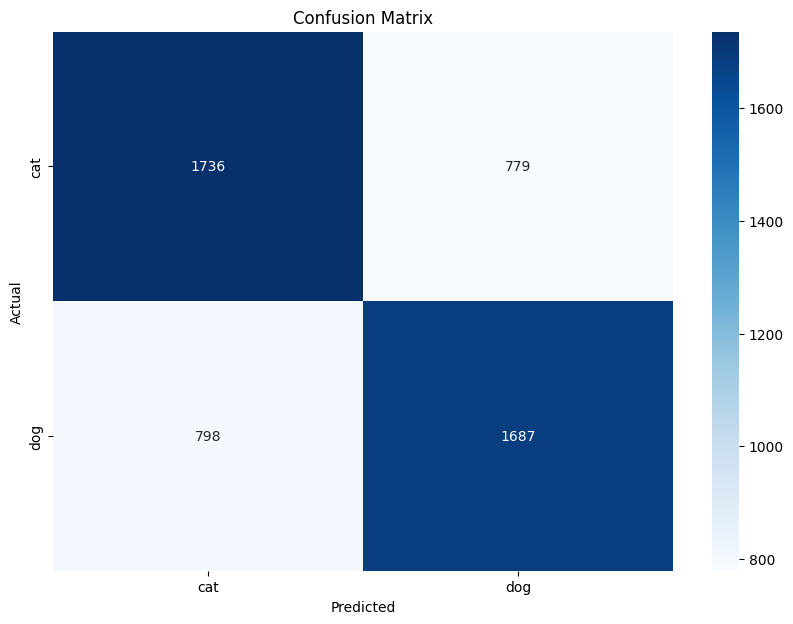

Total Training Time: 9553.53 seconds


In [9]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(confusion_image_path)
plt.show()

# Save the trained model
joblib.dump(best_pipeline, model_file_path)

# Print total time
print(f"Total Training Time: {end_time - start_time:.2f} seconds")
